In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
import catboost as cbr
from sklearn.ensemble import StackingRegressor

In [2]:
df_train = pd.read_csv('/kaggle/input/househabitability/train.csv')
df_test = pd.read_csv('/kaggle/input/househabitability/test.csv')

In [3]:
df_train.head()

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.89,Slightly below average,Medium,90.0,3.86,71.98
1,0x68d4,Apartment,733,2.0,2,Unfurnished,1.0,No,Once in a day - Evening,4.37,Well below average,Medium,96.0,3.55,71.20
2,0x7d81,Apartment,737,4.0,2,Fully Furnished,0.0,No,Once in a day - Morning,7.45,Slightly below average,Medium,121.0,3.81,71.39
3,0x7a57,Apartment,900,3.0,2,Unfurnished,2.0,Yes,Once in a day - Morning,6.16,Well above average,Medium,100.0,1.34,31.46
4,0x9409,Bungalow,2238,14.0,6,Fully Furnished,0.0,No,All time,5.46,Well below average,Medium,116.0,4.77,93.70


In [4]:
df_train.shape

(39499, 15)

In [5]:
df_train.isnull().sum()

Property_ID                  0
Property_Type                0
Property_Area                0
Number_of_Windows         1654
Number_of_Doors              0
Furnishing                1042
Frequency_of_Powercuts    1383
Power_Backup                 0
Water_Supply                 0
Traffic_Density_Score        0
Crime_Rate                 787
Dust_and_Noise            1219
Air_Quality_Index            0
Neighborhood_Review          0
Habitability_score           0
dtype: int64

In [6]:
df_train.columns

Index(['Property_ID', 'Property_Type', 'Property_Area', 'Number_of_Windows',
       'Number_of_Doors', 'Furnishing', 'Frequency_of_Powercuts',
       'Power_Backup', 'Water_Supply', 'Traffic_Density_Score', 'Crime_Rate',
       'Dust_and_Noise', 'Air_Quality_Index', 'Neighborhood_Review',
       'Habitability_score'],
      dtype='object')

In [7]:
df_train.dtypes

Property_ID                object
Property_Type              object
Property_Area               int64
Number_of_Windows         float64
Number_of_Doors             int64
Furnishing                 object
Frequency_of_Powercuts    float64
Power_Backup               object
Water_Supply               object
Traffic_Density_Score     float64
Crime_Rate                 object
Dust_and_Noise             object
Air_Quality_Index         float64
Neighborhood_Review       float64
Habitability_score        float64
dtype: object

In [8]:
df_train.drop(columns = ['Property_ID'], inplace = True)
idx = df_test['Property_ID']
df_test.drop(columns = ['Property_ID'], inplace = True)

In [9]:
quantitative = [r for r in df_train.columns if df_train.dtypes[r] != object]
qualitative = [r for r in df_train.columns if df_train.dtypes[r] == object]

In [10]:
quantitative

['Property_Area',
 'Number_of_Windows',
 'Number_of_Doors',
 'Frequency_of_Powercuts',
 'Traffic_Density_Score',
 'Air_Quality_Index',
 'Neighborhood_Review',
 'Habitability_score']

In [11]:
qualitative

['Property_Type',
 'Furnishing',
 'Power_Backup',
 'Water_Supply',
 'Crime_Rate',
 'Dust_and_Noise']

In [12]:
len(quantitative), len(qualitative)

(8, 6)

In [13]:
for cat in qualitative:
    print(cat, ": ", df_train[cat].unique())

Property_Type :  ['Apartment' 'Bungalow' 'Single-family home' 'Duplex' '#R%$G&867'
 'Container Home']
Furnishing :  ['Semi_Furnished' 'Unfurnished' 'Fully Furnished' nan]
Power_Backup :  ['No' 'Yes' 'NOT MENTIONED']
Water_Supply :  ['Once in a day - Morning' 'Once in a day - Evening' 'All time'
 'NOT MENTIONED' 'Once in two days']
Crime_Rate :  ['Slightly below average' 'Well below average' 'Well above average' nan
 'Slightly above average']
Dust_and_Noise :  ['Medium' nan 'High' 'Low']


In [14]:
(df_train['Property_Type'] == '#R%$G&867').sum()

510

In [15]:
df_train['Property_Type'].value_counts()

Apartment             14596
Single-family home    11477
Duplex                 5806
Bungalow               4238
Container Home         2872
#R%$G&867               510
Name: Property_Type, dtype: int64

In [16]:
df_train['Number_of_Windows'].fillna(df_train['Number_of_Windows'].mean(), inplace = True)
df_test['Number_of_Windows'].fillna(df_train['Number_of_Windows'].mean(), inplace = True)

In [17]:
missing = df_train.isnull().sum()
missing.sort_values(inplace=True)
missing = missing[missing>0]

In [18]:
missing

Crime_Rate                 787
Furnishing                1042
Dust_and_Noise            1219
Frequency_of_Powercuts    1383
dtype: int64

In [19]:
missing_ = df_test.isnull().sum()
missing_.sort_values(inplace=True)
missing_ = missing_[missing_>0]
missing_

Crime_Rate                212
Furnishing                257
Dust_and_Noise            330
Frequency_of_Powercuts    366
dtype: int64

<AxesSubplot:>

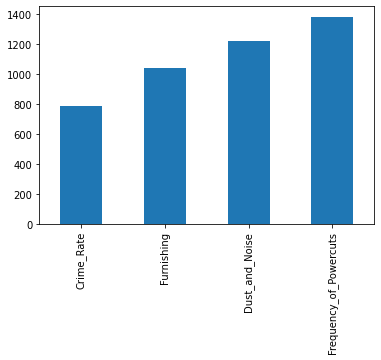

In [20]:
missing.plot.bar()

In [21]:
y = df_train['Habitability_score']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Habitability_score', ylabel='Density'>

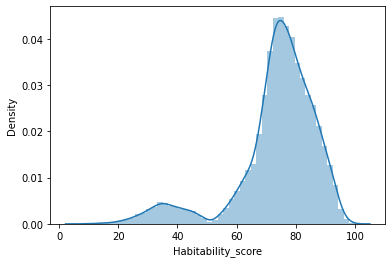

In [22]:
sns.distplot(y)

In [23]:
print("Skewness:", y.skew())

Skewness: -1.5536975975778544


In [24]:
print("Skewness:", df_train['Neighborhood_Review'].skew())

Skewness: -0.7306818071739661


<AxesSubplot:>

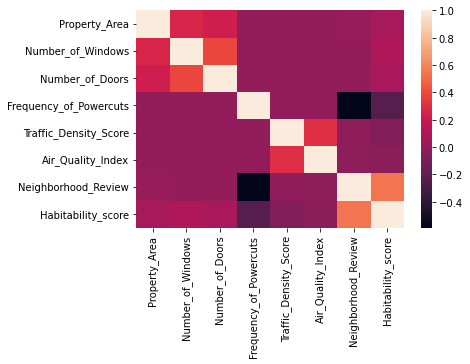

In [25]:
corr = df_train.corr()
sns.heatmap(corr)

In [26]:
corr

,Property_Area,Number_of_Windows,Number_of_Doors,Frequency_of_Powercuts,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Habitability_score
Property_Area,1.000000,0.264963,0.219825,-0.004552,0.000139,0.003673,0.013294,0.065079
Number_of_Windows,0.264963,1.000000,0.386788,-0.002562,-0.001481,0.002882,0.002679,0.092728
Number_of_Doors,0.219825,0.386788,1.000000,-0.000742,-0.001824,0.002055,-0.004360,0.072108
Frequency_of_Powercuts,-0.004552,-0.002562,-0.000742,1.000000,-0.005095,-0.010254,-0.591062,-0.234487
Traffic_Density_Score,0.000139,-0.001481,-0.001824,-0.005095,1.000000,0.300867,-0.017424,-0.070289
Air_Quality_Index,0.003673,0.002882,0.002055,-0.010254,0.300867,1.000000,-0.020819,-0.042233
Neighborhood_Review,0.013294,0.002679,-0.004360,-0.591062,-0.017424,-0.020819,1.000000,0.540033
Habitability_score,0.065079,0.092728,0.072108,-0.234487,-0.070289,-0.042233,0.540033,1.000000


In [27]:
for miss in missing.keys():
    df_train[miss].fillna(df_train[miss].mode()[0], inplace = True)
    df_test[miss].fillna(df_train[miss].mode()[0], inplace = True)

In [28]:
not_mentioned = ['Power_Backup', 'Water_Supply']
for nm in not_mentioned:
    df_train[nm].replace('NOT MENTIONED', df_train[nm].mode()[0], inplace = True)
    df_test[nm].replace('NOT MENTIONED', df_train[nm].mode()[0], inplace = True)

In [29]:
df_train.isnull().sum()

Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
Habitability_score        0
dtype: int64

In [30]:
dfs = [df_train, df_test]
for df in dfs:
    
    df['Furnishing'].replace({'Unfurnished': 0,
                                       'Semi_Furnished': 1,
                                       'Fully Furnished': 2}, inplace = True)
    df['Power_Backup'].replace({'No': 0,
                                     'Yes': 1}, inplace = True)
    df['Water_Supply'].replace({'Once in two days': 0,
                                         'Once in a day - Evening': 1,
                                        'Once in a day - Morning': 2,
                                          'All time': 3}, inplace = True)
    df['Crime_Rate'].replace({'Well below average': 0,
                                       'Slightly below average': 1,
                                        'Slightly above average': 2,
                                        'Well above average': 3}, inplace = True)
    df['Dust_and_Noise'].replace({'Low': 0,
                                           'Medium': 1,
                                           'High': 2}, inplace = True)

In [31]:
labelencoder = LabelEncoder()
df_train['Property_Type'] = labelencoder.fit_transform(df_train['Property_Type'])
df_test['Property_Type'] = labelencoder.transform(df_test['Property_Type'])

In [32]:
df_train

,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,1,106,3.923768,1,1,0.0,0,2,5.89,1,1,90.0,3.86,71.98
1,1,733,2.000000,2,0,1.0,0,1,4.37,0,1,96.0,3.55,71.20
2,1,737,4.000000,2,2,0.0,0,2,7.45,1,1,121.0,3.81,71.39
3,1,900,3.000000,2,0,2.0,1,2,6.16,3,1,100.0,1.34,31.46
4,2,2238,14.000000,6,2,0.0,0,3,5.46,0,1,116.0,4.77,93.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39494,5,1120,3.000000,2,1,0.0,0,3,5.55,2,1,80.0,3.56,73.43
39495,1,445,1.000000,3,2,1.0,0,3,5.70,2,1,86.0,2.93,79.91
39496,2,3780,6.000000,6,0,0.0,1,0,6.84,0,1,137.0,3.80,81.44
39497,5,1266,3.000000,1,1,0.0,0,2,4.60,2,1,88.0,3.25,71.33


<AxesSubplot:>

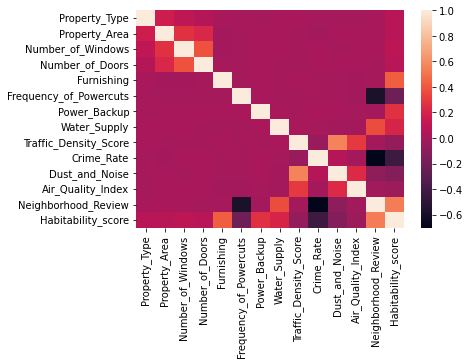

In [33]:
sns.heatmap(df_train.corr())

In [34]:
df_train.corr()

,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
Property_Type,1.000000,0.157021,0.098052,0.057543,0.006040,-0.003016,-0.000982,0.003756,0.002059,-0.003119,-0.001931,-0.002207,0.006499,0.072892
Property_Area,0.157021,1.000000,0.264963,0.219825,-0.005744,-0.003117,0.005684,0.007236,0.000139,-0.011435,0.003751,0.003673,0.013294,0.065079
Number_of_Windows,0.098052,0.264963,1.000000,0.386788,-0.006470,-0.002266,0.003311,0.009480,-0.001481,0.002822,0.000230,0.002882,0.002679,0.092728
Number_of_Doors,0.057543,0.219825,0.386788,1.000000,-0.003993,0.000063,0.007833,-0.003097,-0.001824,0.005595,0.006075,0.002055,-0.004360,0.072108
Furnishing,0.006040,-0.005744,-0.006470,-0.003993,1.000000,0.000476,0.002949,-0.003381,0.004232,0.001825,0.001927,-0.008208,-0.002460,0.421512
Frequency_of_Powercuts,-0.003016,-0.003117,-0.002266,0.000063,0.000476,1.000000,0.004447,0.000133,-0.004498,-0.000554,0.000449,-0.009644,-0.576941,-0.228513
Power_Backup,-0.000982,0.005684,0.003311,0.007833,0.002949,0.004447,1.000000,0.003226,0.001550,0.010126,0.005055,-0.000350,-0.007700,0.264474
Water_Supply,0.003756,0.007236,0.009480,-0.003097,-0.003381,0.000133,0.003226,1.000000,0.005742,-0.004399,-0.004815,-0.004673,0.364574,0.202990
Traffic_Density_Score,0.002059,0.000139,-0.001481,-0.001824,0.004232,-0.004498,0.001550,0.005742,1.000000,-0.046690,0.554731,0.300867,-0.017424,-0.070289
Crime_Rate,-0.003119,-0.011435,0.002822,0.005595,0.001825,-0.000554,0.010126,-0.004399,-0.046690,1.000000,0.048702,-0.011619,-0.703189,-0.436452


In [35]:
x = df_train.drop(columns = 'Habitability_score')

In [36]:
X_train, X_val, y_train, y_val = train_test_split(x, 
                                                    y,
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [37]:
rf = RandomForestRegressor(n_estimators=1000,
                          max_depth = 15)


xt = ExtraTreesRegressor(max_depth = 15)

lgbm = LGBMRegressor()

xgb = XGBRegressor()

cb = cbr.CatBoostRegressor()

estimators = [
     ('rf', RandomForestRegressor(n_estimators=1000,
                          max_depth = 15)),
     ('xt', ExtraTreesRegressor(max_depth = 15)),
    ('lgbm', LGBMRegressor()),
    ('xgb', XGBRegressor()),
    ('cb', cbr.CatBoostRegressor())
]

st = StackingRegressor(estimators=estimators,
                                final_estimator=XGBRegressor(), n_jobs=-1)

In [400]:
def score_dataset(X_train, X_test, y_train, y_test, l):
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    l.append(mean_absolute_error(y_test, preds))
    
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    l.append(mean_absolute_error(y_test, preds))
    
    lgbm.fit(X_train, y_train)
    preds = lgbm.predict(X_test)
    l.append(mean_absolute_error(y_test, preds))
    
    xt.fit(X_train, y_train)
    preds = xt.predict(X_test)
    mean_absolute_error(y_test, preds)
    
    cb.fit(X_train, y_train)
    preds = cb.predict(X_test)
    mean_absolute_error(y_test, preds)

In [403]:
l = []
score_dataset(X_train, X_val, y_train, y_val, l)

[4.551325101265822,
 4.82002348980964,
 4.796649527852976,
 7.4064064554491775,
 5.970588943433183,
 5.602922652552264]

In [415]:
rf = RandomForestRegressor(n_estimators=1000,
                          max_depth = 15)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
mean_absolute_error(y_test, preds)

4.525587466981719

In [38]:
st.fit(X_train, y_train)
preds = st.predict(X_test)
mean_absolute_error(y_test, preds)

Learning rate set to 0.070653
0:	learn: 13.5107962	total: 86.4ms	remaining: 1m 26s
1:	learn: 12.9277672	total: 120ms	remaining: 1m
2:	learn: 12.3694333	total: 161ms	remaining: 53.6s
3:	learn: 11.8585647	total: 202ms	remaining: 50.3s
4:	learn: 11.3914160	total: 233ms	remaining: 46.3s
5:	learn: 10.9725003	total: 264ms	remaining: 43.8s
6:	learn: 10.5781001	total: 296ms	remaining: 42s
7:	learn: 10.2448327	total: 327ms	remaining: 40.6s
8:	learn: 9.9197030	total: 353ms	remaining: 38.8s
9:	learn: 9.6361435	total: 378ms	remaining: 37.4s
10:	learn: 9.3903476	total: 391ms	remaining: 35.2s
11:	learn: 9.1612522	total: 409ms	remaining: 33.7s
12:	learn: 8.9527328	total: 436ms	remaining: 33.1s
13:	learn: 8.7501474	total: 465ms	remaining: 32.7s
14:	learn: 8.5705153	total: 512ms	remaining: 33.6s
15:	learn: 8.4034834	total: 541ms	remaining: 33.3s
16:	learn: 8.2577136	total: 574ms	remaining: 33.2s
17:	learn: 8.1267531	total: 604ms	remaining: 32.9s
18:	learn: 8.0074598	total: 621ms	remaining: 32.1s
19:	le

NameError: name 'X_test' is not defined

996:	learn: 5.5017675	total: 38s	remaining: 114ms
991:	learn: 5.4774703	total: 37.9s	remaining: 306ms
992:	learn: 5.4770728	total: 38s	remaining: 268ms
982:	learn: 5.4700501	total: 38s	remaining: 658ms
969:	learn: 5.4300125	total: 38s	remaining: 1.18s
997:	learn: 5.5013852	total: 38s	remaining: 76.1ms
983:	learn: 5.4699131	total: 38s	remaining: 619ms
993:	learn: 5.4765548	total: 38s	remaining: 229ms
970:	learn: 5.4296224	total: 38.1s	remaining: 1.14s
998:	learn: 5.5009579	total: 38s	remaining: 38.1ms
994:	learn: 5.4761015	total: 38s	remaining: 191ms
984:	learn: 5.4693143	total: 38.1s	remaining: 580ms
999:	learn: 5.5002092	total: 38.1s	remaining: 0us
985:	learn: 5.4689706	total: 38.1s	remaining: 541ms
988:	learn: 5.4672840	total: 38.2s	remaining: 425ms
973:	learn: 5.4277143	total: 38.2s	remaining: 1.02s
998:	learn: 5.4737088	total: 38.2s	remaining: 38.3ms
989:	learn: 5.4669831	total: 38.3s	remaining: 387ms
974:	learn: 5.4269645	total: 38.3s	remaining: 981ms
999:	learn: 5.4730118	total: 

In [ ]:
l={}

rf.fit(x, y)
preds = rf.predict(X_test)
l.append(mean_absolute_error(y_test, preds))

xgb.fit(x, y)
preds = xgb.predict(X_test)
l.append(mean_absolute_error(y_test, preds))

lgbm.fit(x, y)
preds = lgbm.predict(X_test)
l.append(mean_absolute_error(y_test, preds))

xt.fit(x, y)
preds = xt.predict(X_test)
mean_absolute_error(y_test, preds)

cb.fit(x, y)
preds = cb.predict(X_test)
mean_absolute_error(y_test, preds)

st.fit(x, y)
preds = st.predict(X_test)
mean_absolute_error(y_test, preds)

In [404]:
l

[4.551325101265822,
 4.82002348980964,
 4.796649527852976,
 7.4064064554491775,
 5.970588943433183,
 5.602922652552264]

In [ ]:
st.fit(x, y)
preds = st.predict(X_test)
mean_absolute_error(y_test, preds)

Learning rate set to 0.073188
0:	learn: 13.4424732	total: 9.28ms	remaining: 9.27s
1:	learn: 12.8348694	total: 16.4ms	remaining: 8.21s
2:	learn: 12.2753977	total: 23.8ms	remaining: 7.92s
3:	learn: 11.7573090	total: 31.7ms	remaining: 7.9s
4:	learn: 11.2854960	total: 38.8ms	remaining: 7.72s
5:	learn: 10.8696214	total: 46.1ms	remaining: 7.64s
6:	learn: 10.4712820	total: 53.7ms	remaining: 7.62s
7:	learn: 10.1351130	total: 61.4ms	remaining: 7.62s
8:	learn: 9.8137224	total: 70ms	remaining: 7.71s
9:	learn: 9.5274409	total: 77.4ms	remaining: 7.67s
10:	learn: 9.2723404	total: 85.1ms	remaining: 7.65s
11:	learn: 9.0493238	total: 93.2ms	remaining: 7.67s
12:	learn: 8.8494471	total: 101ms	remaining: 7.64s
13:	learn: 8.6574702	total: 108ms	remaining: 7.61s
14:	learn: 8.4852678	total: 115ms	remaining: 7.56s
15:	learn: 8.3262828	total: 122ms	remaining: 7.5s
16:	learn: 8.1905822	total: 129ms	remaining: 7.48s
17:	learn: 8.0538329	total: 137ms	remaining: 7.47s
18:	learn: 7.9386140	total: 145ms	remaining: 7

In [40]:
preds = st.predict(X_val)

In [41]:
mean_absolute_error(y_val, preds)

4.501317480599126

In [42]:
pred = st.predict(df_test)

In [43]:
pred

array([30.852041, 79.77932 , 65.687065, ..., 71.924774, 80.57821 ,
       81.82855 ], dtype=float32)

In [44]:
my_submission = pd.DataFrame({'Property_ID': idx, 'Habitability_score': pred})
my_submission.to_csv('submission_3.csv', index=False)

In [ ]:
importances = model.feature_importances_
forest_importances = pd.Series(importances, index = x.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()